In [1]:
!pip install efficientnet_pytorch torchtoolbox

     |████████████████████████████████| 55 kB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 869 kB 12.5 MB/s eta 0:00:01
  Created wheel for lmdb: filename=lmdb-0.98-cp37-cp37m-linux_x86_64.whl size=260809 sha256=e47fa097efaf1cf56552b52d8632e45e72551f683022895699a9f9ab5898d9fe
  Stored in directory: /home/jupyter/.cache/pip/wheels/9e/24/96/783d4dddcf63e3f8cc92db8b3af3c70cf6d76398bff77f1d5e
Successfully built lmdb


In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2

import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# At least fixing some random seeds. 
# It is still impossible to make results 100% reproducible when using GPU
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:

class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [3]:
from pipelinex import HatchDict
import yaml
params_yaml="""
model:
  =: torch.nn.Sequential
  _:
    - =: pipelinex.ModuleConcat
      _:
        - {=: torch.nn.Conv2d, in_channels: 3, out_channels: 16, kernel_size: [3, 3], stride: [2, 2], padding: [1, 1]}
        - {=: torch.nn.AvgPool2d, kernel_size: [3, 3], stride: [2, 2], padding: [1, 1]}
    - {=: torch.nn.ReLU, _: }
"""

parameters = yaml.safe_load(params_yaml)

model_dict = parameters.get("model")
model= HatchDict(parameters).get("model")
print(model)


Sequential(
  (0): ModuleConcat(
    (0): Conv2d(3, 16, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
    (1): AvgPool2d(kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
  )
  (1): ReLU()
)


In [2]:
class DrawHair:
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randrange(self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img
#     def transform(self,img):
#         return self.__call__(self, img)
    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'

In [3]:
hair_draws = AdvancedHairAugmentation()

img = hair_draws.__call__(np.array(test_jpg))
plt.imshow(img)
plt.show()

NameError: name 'AdvancedHairAugmentation' is not defined

In [6]:
train_transform = transforms.Compose([
    DrawHair(),
    transforms.RandomResizedCrop(size=256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.Cutout(scale=(0.05, 0.007), value=(0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [8]:
arch = EfficientNet.from_pretrained('efficientnet-b5')  # Going to use efficientnet-b1 NN architecture
# skf = StratifiedKFold(n_splits=5, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /home/jupyter/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:02<00:00, 41.7MB/s] 


Loaded pretrained weights for efficientnet-b5


In [9]:
import os 
os.cpu_count()

8

In [5]:
class AdvancedHairAugmentation:
    def __init__(self, hairs: int = 4, hairs_folder: str = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/hair_imgs"):
        self.hairs = hairs
        self.hairs_folder = hairs_folder
        self.hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
    def __call__(self, img):
        n_hairs = random.randint(0, self.hairs)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        img.flags.writeable = True
#         print(img.flags.writeable)
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(self.hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            dst = cv2.add(img_bg, hair_fg)
            
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

In [6]:
hair_draws = AdvancedHairAugmentation(6)

In [7]:
%%time
import cv2
import glob
import os
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from multiprocessing import Manager
manager = Manager()
train_img_path = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_aug/"
train_imgs=glob.glob(train_img_path+"/*")
print(type(train_imgs))
draw_hair = AdvancedHairAugmentation(6)
# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
from PIL import Image
from multiprocessing import Pool
import multiprocessing as multi
OUTPUT_PATH = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/hair_aug/"
def save_transformed_img(img):
    imgCV=cv2.imread(img)
    img_name =os.path.basename(img)
#     img_name = os.path.splitext(img_name)[0]
    transformed_img=draw_hair.__call__(imgCV)
    cv2.imwrite(OUTPUT_PATH + img_name,transformed_img)
# p= Pool(multi.cpu_count())
# p.map(save_transformed_img,train_imgs)
# p.close()


# for i,train_img in enumerate(train_imgs):
#     if i == 0:
#         imgCV = cv2.imread(train_img)
#         print(train_img)
#         print(type(train_img))
#         transformed_img=draw_hair.__call__(imgCV)
#         img_name =os.path.basename(train_img)
#         img_name = os.path.splitext(img_name)[0]
#         print(img_name)
#         print(transformed_img.)
#         transformed_img.show()
#         plt.imshow(imgCV)
#         plt.show()
#         print(cv2.cvtColor(imgCV, cv2.COLOR_BGR2RGB))
#         cv2.imshow(img_name,transformed_img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
# imgCV = cv2.imread(train_img_path)



<class 'list'>
CPU times: user 84 ms, sys: 32 ms, total: 116 ms
Wall time: 132 ms


In [7]:

transformed_img.shape

(4000, 6000, 3)

In [8]:
output_path = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/test.jpg"
cv2.imwrite(output_path, transformed_img)

True

In [12]:
from PIL import Image
img =  Image.open( "/home/jupyter/kaggle/melanoma_repo/data/01_raw/test.jpg")
print(type(img.size))
print(type(img.mode))

<class 'tuple'>
<class 'str'>


In [4]:
import pydicom
d=pydicom.read_file("/home/jupyter/kaggle/melanoma_repo/data/01_raw/train/ISIC_6027558.dcm")
print(d)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7656.2093.1589903583961.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

# augmantaion hair

In [8]:
from PIL import Image,ImageDraw,ImageFilter
import os
CROP_WIDTH =CROP_HEIGHT = 256
BACKGROUND_COLOR = (0,0,0)
BACKGROUND = Image.new("RGB", (CROP_WIDTH,CROP_HEIGHT), (0,0,0))
BILINEAR = Image.BILINEAR

def resize(img,size=(CROP_WIDTH,CROP_HEIGHT),resize_filter=Image.NEAREST):
    return img.resize(size,resize_filter)

def crop_center(pil_img, crop_width=CROP_WIDTH, crop_height=CROP_HEIGHT):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def circuler_crop(img,crop_widht=CROP_WIDTH,crop_height=CROP_HEIGHT,background=BACKGROUND, blur_radius=1,):
#     img = Image.open(img_path)
    img_width,img_height = img.size
    offset = blur_radius * 2
    mask = Image.new("L", img.size, 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((offset, offset, img.size[0] - offset, img.size[1] - offset), fill=255)
    mask = mask.filter(ImageFilter.GaussianBlur(blur_radius))

    return Image.composite(img, background, mask)
#     return img.crop(((img_width - crop_width) // 2,
#                          (img_height - crop_height) // 2,
#                          (img_width + crop_width) // 2,
#                          (img_height + crop_height) // 2))

In [7]:
convert_crop()

TypeError: convert_crop() missing 1 required positional argument: 'img_path'

In [8]:
def convert_crop(img_path,output_dir="/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/"):
    
    img = Image.open(img_path)
    img = resize(img)
    img_np=np.asarray(img).copy()
#     print(img_np.flags)
#     img_np.flags.writeable = True
    img_np = draw_hair.__call__(img_np)
    
    img = crop_center(Image.fromarray(img_np))
    img = circuler_crop(img)
    img_name =os.path.basename(img_path)
    img.save(output_dir + img_name)
# def bulk_convert_crop(imgs):
    

In [44]:
hoge= np.asarray(img)

In [46]:
hoge.flags.writeable = True

In [52]:
%%time
test_jpg = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/jpeg/train/ISIC_6031046.jpg"
# img=Image.open(test_jpg)
# print(img.size)
convert_crop(test_jpg)


  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

CPU times: user 360 ms, sys: 48 ms, total: 408 ms
Wall time: 405 ms


In [10]:
draw_hair=AdvancedHairAugmentation(6)

In [11]:
%%time
import glob
from multiprocessing import Pool
import multiprocessing as multi
from PIL import Image
from multiprocessing import Pool

train_img_path = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/jpeg/train"
train_imgs=glob.glob(train_img_path+"/*")
p= Pool(multi.cpu_count())
p.map(convert_crop,train_imgs)
p.close()

CPU times: user 1.73 s, sys: 1.38 s, total: 3.12 s
Wall time: 8min 55s


In [9]:
output_path ="/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped/"
output_imgs=glob.glob(output_path +"*")
_img=Image.open(output_imgs[0])
print(_img.size)


(256, 256)


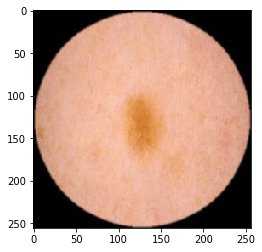

In [13]:
plt.imshow(np.asarray(_img))
plt.show()

In [9]:
from PIL import Image, ImageOps,ImageEnhance
import random
CHOICE_BRIGHTEN = [2,3,5,6,7]
CHOICE_SHARPEN = [2,3,5,6,7]

def flipen(img):
    return ImageOps.flip(img)
def mirroren(img):
    return ImageOps.mirror(img)

def brighten(img):
    con9=ImageEnhance.Brightness(img)
    
    return con9.enhance(random.choice(CHOICE_BRIGHTEN)/4.0)
#     return con9.enhance(7/4.0)


def sharpen(img):
    con11=ImageEnhance.Sharpness(img)
    return con11.enhance(random.choice(CHOICE_SHARPEN)/4.0)


augs = [flipen, brighten,mirroren]

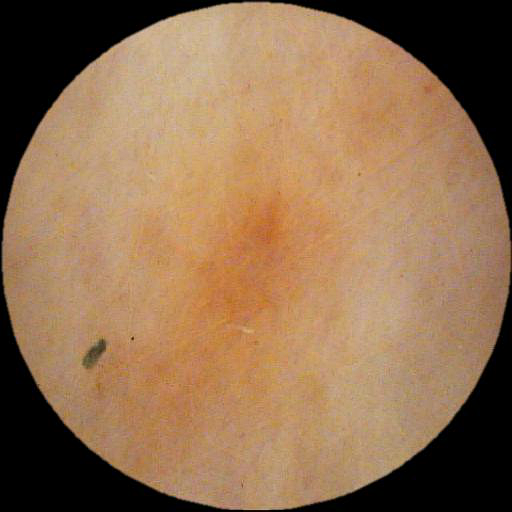

In [91]:
sharpen(test_jpg)


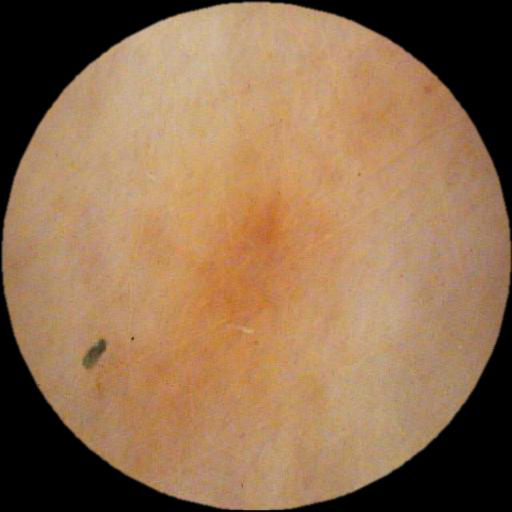

In [81]:
test_jpg

In [16]:
test_jpg = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/ISIC_4066315.jpg"
test_jpg = Image.open(test_jpg)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/ISIC_4066315.jpg'

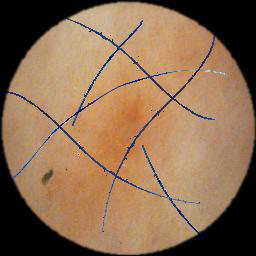

In [15]:
test_jpg

In [14]:
test_jpg.size

(256, 256)

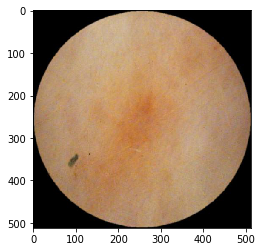

In [5]:
plt.imshow(np.array(test_jpg))
plt.show()

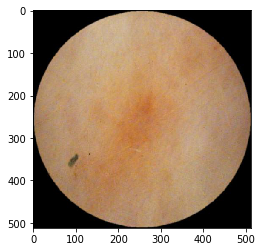

In [86]:
plt.imshow(np.array(flipen(flipen(test_jpg))))
plt.show()

In [61]:
def choose(img,augs=augs):
    candi=2 ** len(augs)
    choice = random.randrange(1,candi)
#     print(choice)
    hoge = []
    for i in range(candi):
        if (choice >> i) &1:
            aug_function=augs[i]
            
            img = aug_function(img)
#             hoge.append(aug_function)
#     print(hoge)
    return img
def convert_random_aug(img_path,output_dir="/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_aug/"):
    img = Image.open(img_path)
#     img = resize(img)
#     img = crop_center(img)
#     img = circuler_crop(img)
    img = choose(img)
    img_name =os.path.basename(img_path)
    
    img.save(output_dir + img_name)
    

In [62]:
%%time
import glob
from multiprocessing import Pool
import multiprocessing as multi


train_img_path = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped"
train_imgs=glob.glob(train_img_path+"/*")
p= Pool(multi.cpu_count())
p.map(convert_random_aug,train_imgs)
p.close()

CPU times: user 220 ms, sys: 240 ms, total: 460 ms
Wall time: 28.3 s


## hair remove

In [4]:
from os import path as opath
test_hair_images =['ISIC_0078712','ISIC_0080817','ISIC_0082348','ISIC_0109869','ISIC_0155012','ISIC_0159568','ISIC_0164145','ISIC_0194550','ISIC_0194914','ISIC_0202023']

path ="/home/jupyter/kaggle/melanoma_repo/data/01_raw/jpeg/train"


In [5]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
    return final_image

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3.8 s, sys: 416 ms, total: 4.21 s
Wall time: 4.21 s


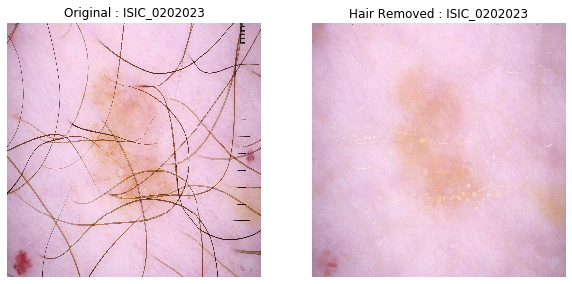

In [6]:
%%time
fig = plt.figure(figsize=(10,5))
for i, img_name in enumerate(test_hair_images):
    img = cv2.imread(opath.join(path,img_name+".jpg"))
    img_resize = cv2.resize(img,(256,256))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_resize,cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original : '+ img_name)
    
    final_image = hair_remove(img_resize)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Hair Removed : '+ img_name)

In [ ]:
cv2.imshow("image",img_resize)


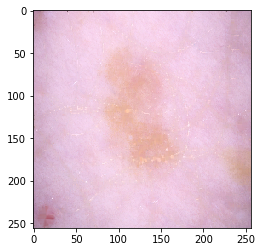

In [13]:
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
